In [2]:
import numpy as np
import pandas as pd

import pickle
import re

import networkx as nx
%matplotlib ipympl
import matplotlib.pyplot as plt
%matplotlib ipympl

import osmnx as ox

import plotly.express as px

#import geopandas as gpd
#import shapely.geometry

My dataset of the whole of Belfast is too big to experiment with graphing. As I'm mainly interested in Short Strand/Ballymacarrett, I'll start with a directory from when this area was counted separately from Belfast. The reason I didn't use this in the first place is that older directories don't have very detailed intersection information. 

Here's an overview of street directories hosted on LennonWylie:
* 1877: Earliest version with street intersections in sequence, Ballymacarrett combined with Belfast, but an additonal [street index](https://lennonwylie.co.uk/1877Appendix.htm#Street%20Index) sometimes notes if a street is in Ballymacarrett (or Mountpottinger) (approx 90 streets)
* 1868: Mountpottinger and Lagan Village are included in Ballymacarrett at https://lennonwylie.co.uk/ballymacarrett1868.htm, separately from Belfast. It includes 14 intersections and usually includes street parts (Rows, Terraces, Places) on their parent streets.
* 1861: Ballymacarrett is separate but mostly lacking intersection data (only four streets have it).
* 1852: Ballymacarrett is separate and has no intersection data but a lot of small rows.

But I can use the 1868 Ballymacarrett at least as a basis to select a subset of streets from the 1877 Belfast directory, or maybe combine the data in other ways.

# (Abandoned) Extract from BSD 1868, html version

It's easier in this version to use the html as a clue to the type of data so I'm importing a parser from BeautifulSoup:

In [74]:
from bs4 import BeautifulSoup

def strip_html(html):
    soup = BeautifulSoup(html, "html.parser")
    return soup.get_text()

In [75]:
def ballymac_bsd_html_to_streets_df(html_file_path):
    with open(html_file_path) as file:
        html_file = file.readlines()

    df_street_gather = pd.DataFrame(columns=['street', 'formerly_street', 'street_segment', 'side', 'from', 'to'])
    current_street = None
    from_to = None

    for line in html_file:
        line_clean = strip_html(line.strip())
        
        if line_clean == '':
            continue
        
        # detect streets
        if line.strip().startswith('<p align="center"><font face="Arial"><b>'):
            if current_street is not None:                
                # before starting a new street, populate a row with last values and add to the DataFrame 
                new_row = {'street':current_street, 'formerly_street':None,'street_segment':None, 'side':None,'from':from_to, 'to':None}
                df_street_gather = pd.concat([df_street_gather, pd.DataFrame([new_row])], ignore_index=True)
                
                from_to = None  # reset from_to for the next street

            current_street = line_clean  # update current street
        
        # detect intersections
        elif ' to ' in line_clean or 'off ' in line_clean:
            from_to = line_clean

    # add the last row 
    if current_street is not None:
        new_row = {'street':current_street, 'formerly_street':None,'street_segment':None, 'side':None,'from':from_to, 'to':None}
        df_street_gather = pd.concat([df_street_gather, pd.DataFrame([new_row])], ignore_index=True)

    return df_street_gather

ballymac_bsd_html_to_streets_df('./data/1868-BSD-Ballymacarrett-Lennon.htm')

,street,formerly_street,street_segment,side,from,to
0,ANDERSON STREET,None,None,None,off Short Strand,None
1,BALLYMACARRETT NEW ROAD,None,None,None,Mountpottinger to Old Road,None
2,BALLYMACARRETT OLD ROAD,None,None,None,off Ballymacarrett Old Road,None
3,BAXTER'S ROW,None,None,None,off Ballymacarrett Old Road,None
4,BEER'S BRIDGE ROAD,None,None,None,off Castlereagh Road,None
...,...,...,...,...,...,...
67,McMILLEN'S BUILDINGS,None,None,None,None,None
68,McMILLEN'S COURT,None,None,None,off Lagan Village,None
69,McMILLEN'S LANE,None,None,None,off Bridge End,None
70,POOLE'S LANE,None,None,None,off Ballymacarrett Old Road,None


# (Abandoned) Extract 1877 data again to include extra information, then filter

I also remebered that in the original 1877 data I had had to bodge a solution for an edge case where extra lines were present after the street name, and these lines indicated that the streets were in Ballymacarrett! I will try to repurpose it to collect a smaller dataset.

In [76]:
def bsd_txt_to_df_areas(txt_file_path):
    target_areas = ['Mountpottinger', 'Ballymacarrett', 'Lagan Village']

    with open(txt_file_path) as file:
        txt_file = file.readlines()

    df_node_gather = pd.DataFrame(columns=['street', 'side', 'node_info', 'node_type'])
    current_street = node_info = node_type = ''
    side = ''
    i = 0

    while i < len(txt_file):
        line = txt_file[i]
        next_line = txt_file[i + 1] if i + 1 < len(txt_file) else ''
        second_next_line = txt_file[i + 2] if i + 2 < len(txt_file) else ''

        # detect street renaming and ignore
        if line.strip() == '' or line.startswith('[Late ') or line.startswith('(Late '):
            i += 1
            continue

        # detect street based on next line contents, assign to variable for now; exclude edge cases; store from-to intersections
        if len(line.split()) < 5 and not '[' in line and (' to ' in next_line or next_line.startswith('Off ')) \
            and not any(char.isdigit() for char in next_line) and not ',' in next_line \
                and not 'door to' in next_line and not 'entrance to' in next_line:
            
            # look for the target_areas and only store these
            if any(area in line or area in next_line or area in second_next_line for area in target_areas):
                current_street = line.strip()
                # but don't store areas as 'node_info' - find the correct line and skip the others
                if next_line.strip() not in target_areas:
                    node_info = next_line.strip()
                    i += 1  # increment i an extra time to avoid processing next line twice
                else:
                    node_info = second_next_line.strip()
                    i += 2  # increment i more if we've gotten to line 3 for the street
                node_type = 'from-to'
                

        # crude detect lines only denoting side of street
        elif ']' in line:
            side = line.strip()
            i += 1
            continue

        # detect sub-street and store the next line, its parent, as the street instead
        elif len(line.split()) < 5 and (next_line.startswith('See ')):
            current_street = next_line.replace('See ', '').strip()
            node_info = line.strip()
            node_type = 'sub-street'
            i += 1  # increment i an extra time to avoid processing next line twice

        # store explicit intersections as nodes and mark them as such
        elif 'intersect' in line.lower():
            node_info = line.strip(".").replace(' intersects', '').replace(' intersect', '').replace('\n', '')
            node_type = 'intersect'

        else:
            node_info = line.strip()

        # Only add to DataFrame if the current_street is in target_areas or is non-empty
        if any(area in current_street for area in target_areas) or any(area in node_info for area in target_areas):
            df_node_gather.loc[len(df_node_gather)] = {
                'street': current_street,
                'side': side,
                'node_info': node_info,
                'node_type': node_type
            }

        # reset per-record variables and increment
        node_info = node_type = ''
        i += 1

    return df_node_gather


df_basic_nodes = bsd_txt_to_df_areas('./data/1877-BSD')
df_basic_nodes


,street,side,node_info,node_type
0,York Street,,"Queen's Quay, Ballymacarrett",
1,Mountpottinger,,Albert Bridge to Ballymacarrett Road,from-to
2,Mountpottinger,,"1 & 3. Canmer, Catherine, spirit dealer",
3,Mountpottinger,,"5. Lorrimer, John, carpenter",
4,Mountpottinger,,"7. McGowan, Samuel, seaman",
...,...,...,...,...
3874,Newtownards Road,[Left side],Ballymacarrett,sub-street
3875,Shankhill Road,[Left Side],Mountpottinger,
3876,Shankhill Road,[Left Side],Mountpottinger,
3877,Shankhill Road,[Left Side],148. Lagan Village National School (No. 2) - J...,


In [77]:
def bsd_txt_to_df_areas(txt_file_path):
    target_areas = ['Mountpottinger', 'Ballymacarrett', 'Lagan Village']

    with open(txt_file_path) as file:
        txt_file = file.readlines()

    df_node_gather = pd.DataFrame(columns=['street', 'side', 'node_info', 'node_type'])
    current_street = node_info = node_type = ''
    side = ''
    i = 0

    while i < len(txt_file):
        line = txt_file[i]
        next_line = txt_file[i + 1] if i + 1 < len(txt_file) else ''
        second_next_line = txt_file[i + 2] if i + 2 < len(txt_file) else ''

        # detect street renaming and ignore
        if line.strip() == '' or line.startswith('[Late ') or line.startswith('(Late '):
            i += 1
            continue

        # detect street based on next line contents, assign to variable for now; exclude edge cases; store from-to intersections
        if len(line.split()) < 5 and not '[' in line and (' to ' in next_line or next_line.startswith('Off ')) \
            and not any(char.isdigit() for char in next_line) and not ',' in next_line \
                and not 'door to' in next_line and not 'entrance to' in next_line:
            
            # look for the target_areas and only store these blocks
            if any(area in line or area in next_line or area in second_next_line for area in target_areas):
                current_street = line.strip()
                # find the correct line and skip the others
                if next_line.strip() in target_areas:
                    node_info = second_next_line.strip()
                    i += 2  # increment i more if we've gotten to line 3 for the street
                else:
                    node_info = next_line.strip()
                    i += 1  # increment i an extra time to avoid processing next line twice
                node_type = 'from-to'
                

        # crude detect lines only denoting side of street
        elif ']' in line:
            side = line.strip()
            i += 1
            continue

        # detect sub-street and store the next line, its parent, as the street instead
        elif len(line.split()) < 5 and (next_line.startswith('See ')):
            current_street = next_line.replace('See ', '').strip()
            node_info = line.strip()
            node_type = 'sub-street'
            i += 1  # increment i an extra time to avoid processing next line twice

        # store explicit intersections as nodes and mark them as such
        elif 'intersect' in line.lower():
            node_info = line.strip(".").replace(' intersects', '').replace(' intersect', '').replace('\n', '')
            node_type = 'intersect'

        else:
            node_info = line.strip()

        # Only add to DataFrame if the current_street is in target_areas or is non-empty
        if any(area in current_street for area in target_areas) or any(area in node_info for area in target_areas):
            df_node_gather.loc[len(df_node_gather)] = {
                'street': current_street,
                'side': side,
                'node_info': node_info,
                'node_type': node_type
            }

        # reset per-record variables and increment
        node_info = node_type = ''
        i += 1

    return df_node_gather


df_basic_nodes = bsd_txt_to_df_areas('./data/1877-BSD')
df_basic_nodes


,street,side,node_info,node_type
0,York Street,,"Queen's Quay, Ballymacarrett",
1,Mountpottinger,,Albert Bridge to Ballymacarrett Road,from-to
2,Mountpottinger,,"1 & 3. Canmer, Catherine, spirit dealer",
3,Mountpottinger,,"5. Lorrimer, John, carpenter",
4,Mountpottinger,,"7. McGowan, Samuel, seaman",
...,...,...,...,...
3874,Newtownards Road,[Left side],Ballymacarrett,sub-street
3875,Shankhill Road,[Left Side],Mountpottinger,
3876,Shankhill Road,[Left Side],Mountpottinger,
3877,Shankhill Road,[Left Side],148. Lagan Village National School (No. 2) - J...,


In [78]:
df_connections = df_basic_nodes[df_basic_nodes['node_type'].isin(['intersect', 'from-to'])][['street', 'node_type', 'node_info']]

df_connections[['from', 'to']] = df_connections['node_info'].str.split(' to ', n=1, expand=True)
df_connections['from'] = df_connections['from'].str.replace('Off ', '')
df_connections['node_type'] = df_connections.apply(lambda row: 'off' if row['node_info'].startswith('Off ') else row['node_type'], axis=1)

df_connections

,street,node_type,node_info,from,to
1,Mountpottinger,from-to,Albert Bridge to Ballymacarrett Road,Albert Bridge,Ballymacarrett Road
17,Mountpottinger,intersect,Woodstock Road,Woodstock Road,None
38,Mountpottinger,intersect,Malcolm Street,Malcolm Street,None
50,Mountpottinger,intersect,Lower Mount Street,Lower Mount Street,None
59,Mountpottinger,intersect,Mount Street,Mount Street,None
...,...,...,...,...,...
3617,Ballymacarrett,intersect,Little York Street,Little York Street,None
3631,Ballymacarrett,intersect,Nelson Street,Nelson Street,None
3659,Ballymacarrett,intersect,Nelson Street,Nelson Street,None
3669,Ballymacarrett,intersect,Little York Street,Little York Street,None


In [79]:
df_nodes = df_basic_nodes.join(df_connections[['node_type', 'from', 'to']], lsuffix='_old')
df_nodes.drop(columns=['node_type_old'], inplace=True)
df_nodes

,street,side,node_info,node_type,from,to
0,York Street,,"Queen's Quay, Ballymacarrett",NaN,NaN,NaN
1,Mountpottinger,,Albert Bridge to Ballymacarrett Road,from-to,Albert Bridge,Ballymacarrett Road
2,Mountpottinger,,"1 & 3. Canmer, Catherine, spirit dealer",NaN,NaN,NaN
3,Mountpottinger,,"5. Lorrimer, John, carpenter",NaN,NaN,NaN
4,Mountpottinger,,"7. McGowan, Samuel, seaman",NaN,NaN,NaN
...,...,...,...,...,...,...
3874,Newtownards Road,[Left side],Ballymacarrett,NaN,NaN,NaN
3875,Shankhill Road,[Left Side],Mountpottinger,NaN,NaN,NaN
3876,Shankhill Road,[Left Side],Mountpottinger,NaN,NaN,NaN
3877,Shankhill Road,[Left Side],148. Lagan Village National School (No. 2) - J...,NaN,NaN,NaN


In [80]:
# add an extra from-to node at the end of each street group
def add_second_from_to_node(grouped_street):
    if 'from-to' in grouped_street['node_type'].values:
        from_to_row = grouped_street[grouped_street['node_type'] == 'from-to'].iloc[0].copy()
        from_to_row['from'] = np.nan
        from_to_row['node_type'] = 'from-to-inverse'
        grouped_street.loc[grouped_street['node_type'] == 'from-to', 'to'] = np.nan
        grouped_street = pd.concat([grouped_street, from_to_row.to_frame().transpose()], ignore_index=True)
    return grouped_street

# apply function to each grouped street to obtain end node
df_nodes = df_nodes.groupby('street').apply(add_second_from_to_node).reset_index(drop=True)

#store the intersecting street, regardless of type
df_nodes['second_street'] = df_nodes['from'].combine_first(df_nodes['to'])

In [81]:
df_nodes[df_nodes['second_street'].notna()]

,street,side,node_info,node_type,from,to,second_street
7,Ballymacarrett,[Left Side],Off Newtownards Road,off,Newtownards Road,None,Newtownards Road
55,Ballymacarrett,[Left Side],Off Newtownards Road,off,Newtownards Road,None,Newtownards Road
104,Ballymacarrett,[Left Side],Off Short Strand,off,Short Strand,None,Short Strand
147,Ballymacarrett,[Left side],Woodstock Road to Lagan Village,from-to,Woodstock Road,NaN,Woodstock Road
158,Ballymacarrett,[Left side],Woodstock Road,intersect,Woodstock Road,None,Woodstock Road
...,...,...,...,...,...,...,...
3850,Mountpottinger Road,[Left side],Bridge End to Albert Bridge Road,from-to-inverse,NaN,Albert Bridge Road,Albert Bridge Road
3851,Murray's Place,[Left hand],Off Lagan Village,off,Lagan Village,None,Lagan Village
3854,My Lady's Road,[Opposite side],Woodstock Road to Lagan Village Road,from-to,Woodstock Road,NaN,Woodstock Road
3856,My Lady's Road,[Opposite side],Woodstock Road to Lagan Village Road,from-to-inverse,NaN,Lagan Village Road,Lagan Village Road


Clean up multiple intersections with "and" by splitting them:

In [82]:
df_nodes[df_nodes['second_street'].fillna('').str.contains(' and ')]

,street,side,node_info,node_type,from,to,second_street
309,Ballymacarrett,[Left side],North Hill Street and McCleery Street,intersect,North Hill Street and McCleery Street,None,North Hill Street and McCleery Street


In [83]:
df_nodes_test = df_nodes.copy()

# get rows with multiple streets in 'second_street' and split to list values
df_multi_streets = df_nodes_test[df_nodes_test['second_street'].fillna('').str.contains(' and ')].copy()
df_multi_streets['second_street'] = df_multi_streets['second_street'].str.split(' and |, ')

# reapply street designation to items in lists ending in "Streets"
def process_list(lst):
    return [item.replace(" Streets", "").strip() + " Street" for item in lst]

df_multi_streets['second_street'] = df_multi_streets['second_street'].apply(lambda x: process_list(x) if any(" Streets" in item for item in x) else x)

# iterate through 'multi' rows and derive new separate rows
new_rows = []
for index, row in df_multi_streets.iterrows():
    for street in row['second_street']:
        new_row = row.copy()
        new_row['second_street'] = street
        new_rows.append(new_row)

# drop original 'multi' rows from main data set
df_nodes_test.drop(df_multi_streets.index, inplace=True)

# convert new rows to a df and concat with main data set
new_df = pd.DataFrame(new_rows)
df_nodes_test = pd.concat([df_nodes_test, new_df]) #, ignore_index=True

# sort by index to ensure sequential order then reset
df_nodes_test.sort_index(inplace=True)
df_nodes_test.reset_index(inplace=True, drop=True)

df_nodes_test[(df_nodes_test['node_info'].str.contains(' and ')) & (df_nodes_test['node_type'].notna())]

,street,side,node_info,node_type,from,to,second_street
309,Ballymacarrett,[Left side],North Hill Street and McCleery Street,intersect,North Hill Street and McCleery Street,None,North Hill Street
310,Ballymacarrett,[Left side],North Hill Street and McCleery Street,intersect,North Hill Street and McCleery Street,None,McCleery Street


In [84]:
df_nodes = df_nodes_test.copy()

After cleaning, I use the same process to create the graph and add connecting edges.

In [85]:
#add the inital nodes, link adjacent nodes on the same street, store second street for intersections
G = nx.Graph()

for index, row in df_nodes.iterrows():
    street = row['street']
    node_type = row['node_type']
    node_info = row['node_info']
    second_street = row['second_street']
    node_id = f"{street}_{index}"
    G.add_node(node_id, street=street, node_type=node_type, second_street=second_street)

    # connect adjacent nodes on the same street
    if index > 0 and df_nodes.at[index - 1, 'street'] == street:
        prev_node_id = f"{street}_{index-1}"
        G.add_edge(node_id, prev_node_id, street=street)

# add connecting edges between connecting streets 
for node in G.nodes(data=True):
    node_id = node[0]
    street = node[1]['street']
    node_type = node[1]['node_type']
    second_street = node[1].get('second_street', None)
        
    # find and gather nodes with matching 'street' and 'second_street'
    matching_nodes = [n for n, data in G.nodes(data=True) if n != node_id and
                        ('street' in data and data['street'] == second_street) and
                        ('second_street' in data and data['second_street'] == street)]

    # add edge between matching nodes
    for matching_node in matching_nodes:
        G.add_edge(node_id, matching_node)

list(G.nodes(data=True))

[('Albert Bridge Road_0',
  {'street': 'Albert Bridge Road', 'node_type': nan, 'second_street': nan}),
 ('Albert Bridge Road_1',
  {'street': 'Albert Bridge Road', 'node_type': nan, 'second_street': nan}),
 ('Albert Bridge Road_2',
  {'street': 'Albert Bridge Road', 'node_type': nan, 'second_street': nan}),
 ('Albert Bridge Road_3',
  {'street': 'Albert Bridge Road', 'node_type': nan, 'second_street': nan}),
 ('Antrim Road_4',
  {'street': 'Antrim Road', 'node_type': nan, 'second_street': nan}),
 ('Antrim Road_5',
  {'street': 'Antrim Road', 'node_type': nan, 'second_street': nan}),
 ('Antrim Road_6',
  {'street': 'Antrim Road', 'node_type': nan, 'second_street': nan}),
 ('Ballymacarrett_7',
  {'street': 'Ballymacarrett',
   'node_type': 'off',
   'second_street': 'Newtownards Road'}),
 ('Ballymacarrett_8',
  {'street': 'Ballymacarrett', 'node_type': nan, 'second_street': nan}),
 ('Ballymacarrett_9',
  {'street': 'Ballymacarrett', 'node_type': nan, 'second_street': nan}),
 ('Ballymacar

Then I need to geocode again for this this smaller dataset.

In [86]:
df_edges = nx.to_pandas_edgelist(G)
df_intersection_edges_googlemaps = df_edges[pd.isna(df_edges['street'])].copy()

# get intersection names with '&'
df_intersection_edges_googlemaps['intersection'] = (
    df_intersection_edges_googlemaps['source'].str.split('_').str[0] +
    ' & ' + df_intersection_edges_googlemaps['target'].str.split('_').str[0]
)

# geocode
from geopy.geocoders import GoogleV3

with open('./data/api_key_googlemaps', 'r') as keyfile:
    api_key = keyfile.read()

geolocator = GoogleV3(api_key)

def geocode_intersection(intersection):
    # attempt to specify only 'intersection' type
    location = geolocator.geocode(intersection + ", Belfast, UK", components={"type":"intersection"})
    responses = {
            'coordinates': (location.latitude, location.longitude),
            'types': location.raw['types'],
            'formatted_address': location.address,
            'partial_match': location.raw.get('partial_match', ""),
            'location_type': location.raw.get('geometry', {}).get('location_type', "")
        }
    return responses

df_intersection_edges_googlemaps[['coordinates', 'types', 'formatted_address', 'partial_match', 'location_type']] = df_intersection_edges_googlemaps['intersection'].apply(geocode_intersection).apply(pd.Series)

df_intersection_edges_googlemaps.head(30)

,source,target,street,intersection,coordinates,types,formatted_address,partial_match,location_type
2148,Beechfield Street_2150,Mountpottinger Road_3720,NaN,Beechfield Street & Mountpottinger Road,"(54.59704199999999, -5.9082077)",[intersection],"Beechfield St & Mountpottinger Rd, Belfast BT5...",,GEOMETRIC_CENTER


# Filter whole 1877 data based on area from separate street list

Extracting again is more difficult than I had anticipated. Instead I will build a list of streets to filter for, based on data from the streets list in the directory.

## Get street list as a DataFrame

In [3]:
def get_streets(file_path_streetlist_txt):
    with open(file_path_streetlist_txt) as file:
        txt_file = file.readlines()

    df_street_gather = pd.DataFrame(columns=['street', 'area', 'second_street'])
    target_areas = ['Mountpottinger', 'Ballymacarrett', 'Lagan Village']
    
    # split the lines into street, area, and second street
    for line in txt_file:
        if ',' in line and any(area in line for area in target_areas):
            parts = line.split(',', 2)
            if len(parts) == 3:
                street, part1, part2 = map(str.strip, parts)
                
                if part1 in target_areas and part2 in target_areas:
                    area, second_street = part1, part2
                elif part1 in target_areas:
                    area, second_street = part1, part2
                elif part2 in target_areas:
                    area, second_street = part2, part1
                else:
                    area, second_street = '', f"{part1}, {part2}"
                
                df_street_gather.loc[len(df_street_gather)] = [street, area, second_street]
            elif len(parts) == 2:
                street, part1 = parts
                part1 = part1.strip()
                
                if part1 in target_areas:
                    area, second_street = part1, ''
                else:
                    area, second_street = '', part1
                
                df_street_gather.loc[len(df_street_gather)] = [street.strip(), area, second_street]

    # clean up abbreviations
    for index, row in df_street_gather.iterrows():
        street = row['street'].replace('Terr.', 'Terrace')

        df_street_gather.at[index, 'street'] = street
        second_street_words = row['second_street'].split()
        for i, word in enumerate(second_street_words):
            if word.endswith(('Rd', 'Rd.')):
                second_street_words[i] = word.replace('Rd', 'Road').replace('Rd.', 'Road')
            elif word == "N'Ards":
                second_street_words[i] = "Newtownards"
        second_street = ' '.join(second_street_words).replace('.', '')

        if second_street.endswith(('St', 'St.')) and len(second_street_words) == 1:
            second_street = second_street[:-2] + 'Street'

        df_street_gather.at[index, 'second_street'] = second_street       
        # Check for three words ending 'Street' or 'Road' with the first word matching any of target_areas
        second_street_parts = second_street.split()
        if len(second_street_parts) == 3 and \
           second_street_parts[0] in target_areas and \
           second_street_parts[-1].endswith(('Street', 'Road')):
            area = second_street_parts[0]
            second_street = ' '.join(second_street_parts[1:])
            df_street_gather.at[index, 'area'] = area
            df_street_gather.at[index, 'second_street'] = second_street

        # add missing streets from second_street
        if second_street:
            new_street = second_street[4:] if second_street.startswith('see ') else second_street
            new_second_street = '' if second_street.startswith('see ') else street
            df_street_gather.loc[len(df_street_gather)] = [new_street, row['area'], new_second_street]

    return df_street_gather


df_ballymac_streets = get_streets('./data/1877-BSD-streets-only')
df_ballymac_streets


,street,area,second_street
0,Abercorn Cottages,Ballymacarrett,
1,Albert Bridge Road,Mountpottinger,
2,Alfred Terrace,,see Mountpottinger Road
3,Ashley Lodge,Ballymacarrett,see Newtownards Road
4,Ashley Place,Mountpottinger,see Albert bridge Road
...,...,...,...
179,Newtownards Road,Ballymacarrett,Trainview
180,Castlereagh Street,Ballymacarrett,
181,Castlereagh Street,Ballymacarrett,
182,Mountpottinger Road,,


## Fix detection

First I pulled the pickled data to work with, but I discovered that the detection needs refining. I first filtered the streets in the whole dataset based on the derived street list, giving 1923 data points:

In [4]:
df_basic_nodes = pd.read_pickle('./data/df_basic_nodes.pkl')

df_connections = df_basic_nodes[df_basic_nodes['node_type'].isin(['intersect', 'from-to'])][['street', 'node_type', 'node_info']]
df_connections[['from', 'to']] = df_connections['node_info'].str.split(' to ', n=1, expand=True)
df_connections['from'] = df_connections['from'].str.replace('Off ', '')
df_connections['node_type'] = df_connections.apply(lambda row: 'off' if row['node_info'].startswith('Off ') else row['node_type'], axis=1)
df_nodes = df_basic_nodes.join(df_connections[['node_type', 'from', 'to']], lsuffix='_old')
df_nodes.drop(columns=['node_type_old'], inplace=True)

# add an extra from-to node at the end of each street group
def add_second_from_to_node(grouped_street):
    if 'from-to' in grouped_street['node_type'].values:
        from_to_row = grouped_street[grouped_street['node_type'] == 'from-to'].iloc[0].copy()
        from_to_row['from'] = np.nan
        from_to_row['node_type'] = 'from-to-inverse'
        grouped_street.loc[grouped_street['node_type'] == 'from-to', 'to'] = np.nan
        grouped_street = pd.concat([grouped_street, from_to_row.to_frame().transpose()], ignore_index=True)
    return grouped_street

# apply function to each grouped street to obtain end node
df_nodes = df_nodes.groupby('street').apply(add_second_from_to_node).reset_index(drop=True)

#store the intersecting street, regardless of type
df_nodes['second_street'] = df_nodes['from'].combine_first(df_nodes['to'])

df_nodes_test = df_nodes.copy()

# get rows with multiple streets in 'second_street' and split to list values
df_multi_streets = df_nodes_test[df_nodes_test['second_street'].fillna('').str.contains(' and ')].copy()
df_multi_streets['second_street'] = df_multi_streets['second_street'].str.split(' and |, ')

# reapply street designation to items in lists ending in "Streets"
def process_list(lst):
    return [item.replace(" Streets", "").strip() + " Street" for item in lst]

df_multi_streets['second_street'] = df_multi_streets['second_street'].apply(lambda x: process_list(x) if any(" Streets" in item for item in x) else x)

# iterate through 'multi' rows and derive new separate rows
new_rows = []
for index, row in df_multi_streets.iterrows():
    for street in row['second_street']:
        new_row = row.copy()
        new_row['second_street'] = street
        new_rows.append(new_row)

# drop original 'multi' rows from main data set
df_nodes_test.drop(df_multi_streets.index, inplace=True)

# convert new rows to a df and concat with main data set
new_df = pd.DataFrame(new_rows)
df_nodes_test = pd.concat([df_nodes_test, new_df]) #, ignore_index=True

# sort by index to ensure sequential order then reset
df_nodes_test.sort_index(inplace=True)
df_nodes_test.reset_index(inplace=True, drop=True)

df_nodes = df_nodes_test.copy()

df_nodes_ballymac = df_nodes[df_nodes['street'].isin(df_ballymac_streets['street']) | df_nodes['second_street'].isin(df_ballymac_streets['street'])]
df_nodes_ballymac

,street,side,node_info,node_type,from,to,second_street
610,Albert Bridge Road,,Albert Bridge to Ballymacarrett Road,from-to,Albert Bridge,NaN,Albert Bridge
611,Albert Bridge Road,,"1 & 3. Canmer, Catherine, spirit dealer",NaN,NaN,NaN,NaN
612,Albert Bridge Road,,"5. Lorrimer, John, carpenter",NaN,NaN,NaN,NaN
613,Albert Bridge Road,,"7. McGowan, Samuel, seaman",NaN,NaN,NaN,NaN
614,Albert Bridge Road,,"9 & 11. Millen, Dan., seaman",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
38341,Woodstock Place,,Moore Street,intersect,Moore Street,None,Moore Street
38509,Woodstock Street,,Off Albert Bridge Road,off,Albert Bridge Road,None,Albert Bridge Road
38965,Young's Place,,Off Newtownards Road,off,Newtownards Road,None,Newtownards Road
38967,Young's Row,,Off Newtownards Road,off,Newtownards Road,None,Newtownards Road


However, when I run a check for any new intersections that emerge from the street list that are not in the main data, it becomes that in fact whole streets are missing from the main data. This is more likely to occur for streets in mt target area as they are more often presented in the original file with an irregular format. Here are the new street combinations I found:

In [5]:
filtered_ballymac_streets = df_ballymac_streets[
    (df_ballymac_streets['second_street'] != '') &
    (~df_ballymac_streets['second_street'].str.startswith('see '))
]

filtered_nodes = df_nodes[df_nodes['node_type'].notna()]

unique_combinations_test = filtered_ballymac_streets[
    ~filtered_ballymac_streets.apply(
        lambda row: ((filtered_nodes['street'] == row['street']) &
                     (filtered_nodes['second_street'] == row['second_street'])).any(), 
        axis=1
    )
]

unique_combinations_test

,street,area,second_street
6,Baltic Street,Ballymacarrett,Bridge End
7,Baltic Street East,Ballymacarrett,Bridge End
15,Bridge End,Ballymacarrett,Queen's Bridge
19,Castlereagh Place,Mountpottinger,Castlereagh Street
20,Castlereagh Road,Ballymacarrett,Loop Bridge
...,...,...,...
173,Beersbridge Road,Ballymacarrett,Steen's Row
174,Beersbridge Road,Ballymacarrett,Tamery Street
176,Albert Bridge Road,Ballymacarrett,Templemore Street
178,Templemore Park,Ballymacarrett,Thorndyke Street


TODO: fix single line street detection with clear line above and below and no number in line

The original logic only looked for 'Off ' or ' to ', but, for example in the intance of Baltic Street, the street line was followed with simply 'Bridge End, Ballymacarrett'. This happens with ten streets in Ballymacarrett, which would have been skipped in the original logic. I will refine this now:

In [6]:
def bsd_txt_to_df_basic_nodes_2(txt_file_path):
    with open(txt_file_path) as file:
        txt_file = file.readlines()

    df_node_gather = pd.DataFrame(columns=['street', 'side', 'node_info', 'node_type'])
    current_street = node_info = ''
    i = 0 

    while i < len(txt_file):
        line = txt_file[i]
        next_line = txt_file[i + 1] if i + 1 < len(txt_file) else ''  # with EOF protection
        prev_line = txt_file[i - 1] if i - 1 >= 0 else ''

        # detect street renaming and skip
        if line.strip() == '' or line.startswith('[Late ') or line.startswith('(Late '):
            i += 1
            continue

        # crude detect lines only denoting side of street even when not directly under street
        if ']' in line:
            side = line.strip()
            i += 1
            continue
        
        # store explicit intersections as nodes and mark them as such
        if 'intersect' in line.lower():
            node_info = line.strip(".").replace(' intersects', '').replace(' intersect', '').replace('\n', '')
            node_type = 'intersect'
        else:
            # detect street based on line and next line contents
            if prev_line.strip() == '' and len(line.split()) < 5 and not '[' in line and not ' to ' in line and not 'intersect' in line \
                and not any(char.isdigit() for char in line) and not "__" in line\
                and (' to ' in next_line or next_line.startswith('Off ') or next_line.startswith('From ') or '[' in next_line 
                     or 'Road' in next_line or 'Street' in next_line or ', Ballymacarrett' in next_line or next_line.strip() == 'Mountpottinger' 
                     or next_line.strip() == 'Ballymacarrett' or next_line.strip() == '') \
                and not 'door to' in next_line and not '.......' in next_line and not 'entrance to' in next_line.lower():

                    current_street = line.strip().replace(', Ballymacarrett', '')
                    side = ''  # reset for now
                    
                    # solve extra line for district or side: skip it and get node info from line below
                    if next_line.strip() == 'Mountpottinger' or next_line.strip() == 'Ballymacarrett': 
                        next_line = txt_file[i + 2]
                        i += 1
                    elif ']' in next_line:
                        side = next_line.strip()
                        next_line = txt_file[i + 2]
                        i += 1

                    i += 1  # increment i an extra time to avoid processing next_line a second time as line

            # detect sub-street
            if next_line.strip().startswith('See '):
                current_street = next_line.strip().replace('See ', '').replace(', Ballymacarrett', '')
                node_info = line.strip().replace(', Ballymacarrett', '')
                node_type = 'sub-street'

            # otherwise look for from-to info
            elif (' to ' in next_line or next_line.strip().startswith('Off ') or next_line.strip().startswith('From ') \
                or 'Road' in next_line or 'Street' in next_line) \
                and not 'door to' in next_line and not 'entrance to' in next_line.lower() \
                and not any(char.isdigit() for char in line):
                node_info = next_line.strip()
                node_type = 'from-to'

            elif next_line.strip().endswith(', Ballymacarrett'):
                node_info = next_line.strip().replace(', Ballymacarrett', '')
                node_type = 'from-to'

            else:
                node_info = line.strip()

        df_node_gather.loc[len(df_node_gather)] = {
            'street': current_street,
            'side': side,
            'node_info': node_info,
            'node_type': node_type
        }

        # reset per-record variables and increment
        node_info = node_type = ''
        i += 1

    return df_node_gather

df_basic_nodes_2 = bsd_txt_to_df_basic_nodes_2('./data/1877-BSD')


Now I need to complete all other transformation steps to derive a dataframe `df_nodes_2` with the data properly separated into columns, first modifying the steps based on the format of the new data gathered in `df_basic_nodes_2`. 

In [7]:
df_connections = df_basic_nodes_2[df_basic_nodes_2['node_type'].isin(['intersect', 'from-to'])][['street', 'node_type', 'node_info']]
df_connections[['from', 'to']] = df_connections['node_info'].str.split(' to ', n=1, expand=True)
df_connections['from'] = df_connections['from'].str.replace('Off ', '')
df_connections['node_type'] = df_connections.apply(lambda row: 'off' if row['node_info'].startswith('Off ') else row['node_type'], axis=1)
df_nodes_2 = df_basic_nodes_2.join(df_connections[['node_type', 'from', 'to']], lsuffix='_old')
df_nodes_2.drop(columns=['node_type_old'], inplace=True)

# add an extra from-to node at the end of each street group
def add_second_from_to_node(grouped_street):
    if 'from-to' in grouped_street['node_type'].values:
        from_to_row = grouped_street[grouped_street['node_type'] == 'from-to'].iloc[0].copy()
        from_to_row['from'] = None
        from_to_row['node_type'] = 'from-to-inverse'
        grouped_street.loc[grouped_street['node_type'] == 'from-to', 'to'] = None
        grouped_street = pd.concat([grouped_street, from_to_row.to_frame().transpose()], ignore_index=True)
    return grouped_street

# apply function to each grouped street to obtain end node
df_nodes_2 = df_nodes_2.groupby('street').apply(add_second_from_to_node).reset_index(drop=True)

# store the intersecting street from either from or to in a single column
df_nodes_2['second_street'] = df_nodes_2['from'].combine_first(df_nodes_2['to'])
# add an additional step for area or other non-street info after a comma, but retain unnamed or multiple streets
df_nodes_2['second_street'] = df_nodes_2['second_street'].apply(lambda x: x.split(',')[0] if isinstance(x, str) and 'named' not in x and ' and ' not in x else x)

# handle multiple streets in the same field
df_nodes_test_2 = df_nodes_2.copy()

# get rows with multiple streets in 'second_street' and split to list values
df_multi_streets = df_nodes_test_2[df_nodes_test_2['second_street'].fillna('').str.contains(' and ')].copy()
df_multi_streets['second_street'] = df_multi_streets['second_street'].str.split(' and |, ')

# reapply street designation to items in lists ending in "Streets"
def process_list(lst):
    return [item.replace(" Streets", "").strip() + " Street" for item in lst]

df_multi_streets['second_street'] = df_multi_streets['second_street'].apply(lambda x: process_list(x) if any(" Streets" in item for item in x) else x)

# iterate through 'multi' rows and derive new separate rows
new_rows = []
for index, row in df_multi_streets.iterrows():
    for street in row['second_street']:
        new_row = row.copy()
        new_row['second_street'] = street
        new_rows.append(new_row)

# drop original 'multi' rows from main data set
df_nodes_test_2.drop(df_multi_streets.index, inplace=True)

# convert new rows to a df and concat with main data set
new_df = pd.DataFrame(new_rows)
df_nodes_test_2 = pd.concat([df_nodes_test_2, new_df]) #, ignore_index=True

# sort by index to ensure sequential order then reset
df_nodes_test_2.sort_index(inplace=True)
df_nodes_test_2.reset_index(inplace=True, drop=True)

df_nodes_2 = df_nodes_test_2.copy()
df_nodes_2

,street,side,node_info,node_type,from,to,second_street
0,Abbey Street,,North King Street to Peter's Hill,from-to,North King Street,None,North King Street
1,Abbey Street,,"1. Donaldson, Wm.",NaN,NaN,NaN,NaN
2,Abbey Street,,"3. Craggan, John, musician",NaN,NaN,NaN,NaN
3,Abbey Street,,"5. Ireland, Alex., flax dresser",NaN,NaN,NaN,NaN
4,Abbey Street,,"7. Long, John",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
38997,Zetland Street,,"8. Clarke, James, her Majesty's Court of Probate",NaN,NaN,NaN,NaN
38998,Zetland Street,,"6. Morrow, Mrs.",NaN,NaN,NaN,NaN
38999,Zetland Street,,"4. Lynas, Joseph, boot maker",NaN,NaN,NaN,NaN
39000,Zetland Street,,"2. Fleming, James, insurance agent",NaN,NaN,NaN,NaN


I perform checks by reviewing the changes to the extracted data in the whole data set by comparing the old and new DataFrames.

In [8]:
# add columns indicating source
df_nodes_copy = df_nodes.copy()
df_nodes_2_copy = df_nodes_2.copy()
df_nodes_copy.insert(0, 'source', 1)
df_nodes_2_copy.insert(0, 'source', 2)

# combine and compare, ingnoring source column
concatenated = pd.concat([df_nodes_copy, df_nodes_2_copy])
columns_to_check = df_nodes.columns.tolist()
compare_df_nodes = concatenated.drop_duplicates(subset=columns_to_check, keep=False)

compare_df_nodes

,source,street,side,node_info,node_type,from,to,second_street
62,1,Abbot Street,,Abercorn Basin,NaN,NaN,NaN,NaN
63,1,Abbot Street,,"Queen's Quay, Ballymacarrett",NaN,NaN,NaN,NaN
64,1,Abbot Street,,"1 & 2. Humphrys, L. J., Agent for Wigan Coal a...",NaN,NaN,NaN,NaN
65,1,Abbot Street,,Ulster Iron Works,NaN,NaN,NaN,NaN
66,1,Abbot Street,,"MacIlwaine & Lewis, Engineers, Boilermakers an...",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
38528,2,Woodstock Road,,"12. Nicholl, Wm.",NaN,NaN,NaN,NaN
38529,2,Woodstock Road,,"10. Lagan Village National School - W. Moore, ...",NaN,NaN,NaN,NaN
38530,2,Woodstock Road,,"8. McBride, Agnes, sempstress",NaN,NaN,NaN,NaN
38531,2,Woodstock Road,,"6. Finlay, Wm.",NaN,NaN,NaN,NaN


The data in `df_nodes_2` also needs to be cleaned to handle the incosistent naming of streets with 'North', 'Upper', 'Back', etc.

In [9]:
def transform_street_names(df):
    # copy input to new df to leave original unchanged
    df_transformed = df.copy()
    
    def transform_street(street):
        if pd.isna(street):
            return street
        
        # find and move '(back)' or '(Back)'
        if '(back)' in street.lower():
            street = re.sub(r'\(back\)|\(Back\)', '', street, flags=re.IGNORECASE).strip() + ' Back'

        # don't modify streets called simply eg "North Street"
        words = street.split()
        if len(words) < 3:
            return street
        
        # modify streets starting with specified qualifiers
        else:
            qualifiers = ['North', 'South', 'East', 'West', 'Great', 'Little', 'Upper', 'Lower']
            
            for qualifier in qualifiers:
                if street.startswith(qualifier):
                    return street[len(qualifier):].strip() + ' ' + qualifier
            
            return street.strip()
    
    # apply transformation to columns
    df_transformed['street'] = df_transformed['street'].apply(lambda x: transform_street(str(x)) if not pd.isna(x) else np.nan)
    df_transformed['second_street'] = df_transformed['second_street'].apply(lambda x: transform_street(str(x)) if not pd.isna(x) else np.nan)

    return df_transformed

df_nodes_2 = transform_street_names(df_nodes_2)


## Add data from street list

Now I can look again at any street intersections arising from the street list that are not found in the now-updated data.

In [10]:
#filter to include only intersections in street list df and node df
filtered_ballymac_streets = df_ballymac_streets[(df_ballymac_streets['second_street'] != '') &
    (~df_ballymac_streets['second_street'].str.startswith('see '))]
filtered_nodes = df_nodes_2[df_nodes_2['node_type'].notna()]

# check street list df intersections for new street combinations
unique_combinations = filtered_ballymac_streets[
    ~filtered_ballymac_streets.apply(
        lambda row: ((filtered_nodes['street'] == row['street']) &
                     (filtered_nodes['second_street'] == row['second_street'])).any(), axis=1)]

unique_combinations

,street,area,second_street
19,Castlereagh Place,Mountpottinger,Castlereagh Street
21,Castlereagh Street,Mountpottinger,Albert Bridge Road
24,Church Street (back) East,Ballymacarrett,Newtownards Road
31,Club Row Upper,Ballymacarrett,Short Street
64,Independent Street,Ballymacarrett,Short Street
66,Lord Street,Ballymacarrett,Albert bridge Road
68,Malcolm Lane,Ballymacarrett,Claremont Lane
77,Morgan's Buildings,Ballymacarrett,Thompson Street
96,Trainview,Ballymacarrett,Newtownards Road
107,Bridge End,Ballymacarrett,Baltic Street


Now I can filter the data again based on the street list, which shows that the corrections to the algorithm have produced about one-third more nodes.

In [11]:
df_nodes_ballymac_2 = df_nodes_2[df_nodes_2['street'].isin(df_ballymac_streets['street']) | df_nodes_2['second_street'].isin(df_ballymac_streets['street'])].reset_index()
df_nodes_ballymac_2

,index,street,side,node_info,node_type,from,to,second_street
0,62,Abercorn Basin,,Queen's Quay,from-to,Queen's Quay,None,Queen's Quay
1,609,Albert Bridge Road,,Albert Bridge to Ballymacarrett Road,from-to,Albert Bridge,None,Albert Bridge
2,610,Albert Bridge Road,,"1 & 3. Canmer, Catherine, spirit dealer",NaN,NaN,NaN,NaN
3,611,Albert Bridge Road,,"5. Lorrimer, John, carpenter",NaN,NaN,NaN,NaN
4,612,Albert Bridge Road,,"7. McGowan, Samuel, seaman",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2817,38531,Woodstock Road,,"6. Finlay, Wm.",NaN,NaN,NaN,NaN
2818,38532,Woodstock Street,,Off Albert Bridge Road,off,Albert Bridge Road,None,Albert Bridge Road
2819,38988,Young's Place,,Off Newtownards Road,off,Newtownards Road,None,Newtownards Road
2820,38990,Young's Row,,Off Newtownards Road,off,Newtownards Road,None,Newtownards Road


The following of which are intersections:

In [12]:
df_nodes_ballymac_2[df_nodes_ballymac_2['second_street'].notna()]

,index,street,side,node_info,node_type,from,to,second_street
0,62,Abercorn Basin,,Queen's Quay,from-to,Queen's Quay,None,Queen's Quay
1,609,Albert Bridge Road,,Albert Bridge to Ballymacarrett Road,from-to,Albert Bridge,None,Albert Bridge
17,625,Albert Bridge Road,,Woodstock Road,intersect,Woodstock Road,None,Woodstock Road
38,646,Albert Bridge Road,,Malcolm Street,intersect,Malcolm Street,None,Malcolm Street
50,658,Albert Bridge Road,,Lower Mount Street,intersect,Lower Mount Street,None,Mount Street Lower
...,...,...,...,...,...,...,...,...
2665,38379,Woodstock Road,,Woodstock Place,intersect,Woodstock Place,None,Woodstock Place
2785,38499,Woodstock Road,,Mount Street,intersect,Mount Street,None,Mount Street
2818,38532,Woodstock Street,,Off Albert Bridge Road,off,Albert Bridge Road,None,Albert Bridge Road
2819,38988,Young's Place,,Off Newtownards Road,off,Newtownards Road,None,Newtownards Road


# NetworkX Graph object

In [13]:
#add the inital nodes, link adjacent nodes on the same street, store second street for intersections
G = nx.Graph()

for index, row in df_nodes_ballymac_2.iterrows():
    street = row['street']
    node_type = row['node_type']
    node_info = row['node_info']
    second_street = row['second_street']
    node_id = f"{street}_{index}" #add a descriptive unique node id - use original (whole city) index in case of future combination of data
    G.add_node(node_id, street=street, node_type=node_type, second_street=second_street)

    # connect adjacent nodes on the same street
    if index > 0 and df_nodes_ballymac_2.at[index - 1, 'street'] == street:
        prev_node_id = f"{street}_{index-1}"
        G.add_edge(node_id, prev_node_id, street=street)

df_edges = nx.to_pandas_edgelist(G)
df_edges

,source,target,street
0,Albert Bridge Road_1,Albert Bridge Road_2,Albert Bridge Road
1,Albert Bridge Road_2,Albert Bridge Road_3,Albert Bridge Road
2,Albert Bridge Road_3,Albert Bridge Road_4,Albert Bridge Road
3,Albert Bridge Road_4,Albert Bridge Road_5,Albert Bridge Road
4,Albert Bridge Road_5,Albert Bridge Road_6,Albert Bridge Road
...,...,...,...
2668,Woodstock Road_2813,Woodstock Road_2814,Woodstock Road
2669,Woodstock Road_2814,Woodstock Road_2815,Woodstock Road
2670,Woodstock Road_2815,Woodstock Road_2816,Woodstock Road
2671,Woodstock Road_2816,Woodstock Road_2817,Woodstock Road


In [14]:
G.nodes(data=True)

NodeDataView({'Abercorn Basin_0': {'street': 'Abercorn Basin', 'node_type': 'from-to', 'second_street': "Queen's Quay"}, 'Albert Bridge Road_1': {'street': 'Albert Bridge Road', 'node_type': 'from-to', 'second_street': 'Albert Bridge'}, 'Albert Bridge Road_2': {'street': 'Albert Bridge Road', 'node_type': nan, 'second_street': nan}, 'Albert Bridge Road_3': {'street': 'Albert Bridge Road', 'node_type': nan, 'second_street': nan}, 'Albert Bridge Road_4': {'street': 'Albert Bridge Road', 'node_type': nan, 'second_street': nan}, 'Albert Bridge Road_5': {'street': 'Albert Bridge Road', 'node_type': nan, 'second_street': nan}, 'Albert Bridge Road_6': {'street': 'Albert Bridge Road', 'node_type': nan, 'second_street': nan}, 'Albert Bridge Road_7': {'street': 'Albert Bridge Road', 'node_type': nan, 'second_street': nan}, 'Albert Bridge Road_8': {'street': 'Albert Bridge Road', 'node_type': nan, 'second_street': nan}, 'Albert Bridge Road_9': {'street': 'Albert Bridge Road', 'node_type': nan, 's

In [15]:
# add edges joining intersection nodes 
for node in G.nodes(data=True):
    node_id = node[0]
    street = node[1].get('street', '')
    node_type = node[1].get('node_type', '')
    second_street = node[1].get('second_street', '')

    if street == '' or second_street == '':
        continue

    # find and gather nodes with matching 'street' and 'second_street'
    matching_nodes = [n for n, data in G.nodes(data=True) 
                      if n != node_id and
                      data.get('street', '') == second_street and
                      data.get('second_street', '') == street]

    # add edge between matching nodes
    for matching_node in matching_nodes:
        G.add_edge(node_id, matching_node)

df_edges = nx.to_pandas_edgelist(G)
df_edges


,source,target,street
0,Albert Bridge Road_1,Albert Bridge Road_2,Albert Bridge Road
1,Albert Bridge Road_2,Albert Bridge Road_3,Albert Bridge Road
2,Albert Bridge Road_3,Albert Bridge Road_4,Albert Bridge Road
3,Albert Bridge Road_4,Albert Bridge Road_5,Albert Bridge Road
4,Albert Bridge Road_5,Albert Bridge Road_6,Albert Bridge Road
...,...,...,...
2728,Woodstock Road_2813,Woodstock Road_2814,Woodstock Road
2729,Woodstock Road_2814,Woodstock Road_2815,Woodstock Road
2730,Woodstock Road_2815,Woodstock Road_2816,Woodstock Road
2731,Woodstock Road_2816,Woodstock Road_2817,Woodstock Road


TODO: (improvement to index numbering system) do this earier in the df before generating the graph in order to assign sequential numbers. Possibly appy to all data before area filtering.


Here I will add an step to add any extra intersections (as an edge) from the intersection list generated above from the separate street list in the directory.

In [16]:
# add extra street list intersections to the graph
for index, row in unique_combinations.iterrows():
    street = row['street']
    second_street = row['second_street']
    
    # check if an intersection node for combination already exists
    intersection_exists = any(
        (data['street'] == street and data['second_street'] == second_street) or
        (data['street'] == second_street and data['second_street'] == street)
        for node, data in G.nodes(data=True)
        if not (pd.isna(data['street']) or pd.isna(data['second_street']))
    )

    if not intersection_exists:
        # add two new intersection nodes with index names
        node_id_1 = f"{street}_i_{index}"
        node_id_2 = f"{second_street}_i_{index}"
        G.add_node(node_id_1, street=street, node_type='intersect', second_street=second_street)
        G.add_node(node_id_2, street=second_street, node_type='intersect', second_street=street)
        
        # connect new nodes with edge
        G.add_edge(node_id_1, node_id_2)

df_edges_2 = nx.to_pandas_edgelist(G)

df_edges_2


,source,target,street
0,Albert Bridge Road_1,Albert Bridge Road_2,Albert Bridge Road
1,Albert Bridge Road_2,Albert Bridge Road_3,Albert Bridge Road
2,Albert Bridge Road_3,Albert Bridge Road_4,Albert Bridge Road
3,Albert Bridge Road_4,Albert Bridge Road_5,Albert Bridge Road
4,Albert Bridge Road_5,Albert Bridge Road_6,Albert Bridge Road
...,...,...,...
2735,Independent Street_i_64,Short Street_i_64,NaN
2736,Lord Street_i_66,Albert bridge Road_i_66,NaN
2737,Malcolm Lane_i_68,Claremont Lane_i_68,NaN
2738,Morgan's Buildings_i_77,Thompson Street_i_77,NaN


## Geocode intersections

Geocoding returns 75 sets of coordinates with strict filtering for API responses that are intersections. 257 items are found without filtering but the majority are incorrect.

In [17]:
#note: updated to reject non-intersection API responses

from geopy.geocoders import GoogleV3

with open('./data/api_key_googlemaps', 'r') as keyfile:
    api_key = keyfile.read()

geolocator = GoogleV3(api_key)

def geocode_intersection_2(node_attrs):
    location = geolocator.geocode(node_attrs['street'] + " & " + node_attrs['second_street'] + ", Belfast, UK", components={"type":"intersection"})
    if location and 'intersection' in location.raw.get('types', []):
        return (location.latitude, location.longitude)

for node_key, node_attrs in G.nodes(data=True):
    if 'second_street' in node_attrs and not pd.isna(node_attrs['second_street']):
        coord = geocode_intersection_2(node_attrs)
        if coord: node_attrs['coordinates'] = coord 

df_G_nodes = pd.DataFrame.from_dict(G.nodes, orient='index')
df_G_nodes[df_G_nodes['coordinates'].notna()]

,street,node_type,second_street,coordinates
Albert Bridge Road_86,Albert Bridge Road,intersect,Castlereagh Street,"(54.5951068, -5.9050161)"
Albert Bridge Road_98,Albert Bridge Road,intersect,Stormount Street,"(54.59520269999999, -5.9034024)"
Albert Bridge Road_111,Albert Bridge Road,intersect,Frank Street,"(54.5953189, -5.9024136)"
Albert Bridge Road_114,Albert Bridge Road,intersect,Templemore Avenue,"(54.5954874, -5.901500599999999)"
Albert Bridge Road_123,Albert Bridge Road,intersect,Templemore Avenue,"(54.5954874, -5.901500599999999)"
...,...,...,...,...
Thorndyke Street_2572,Thorndyke Street,off,Templemore Park,"(54.59503789999999, -5.9013787)"
Woodstock Road_2785,Woodstock Road,intersect,Mount Street,"(54.5940428, -5.9072137)"
Newtownards Road_i_24,Newtownards Road,intersect,Church Street (back) East,"(54.5958723, -5.7091661)"
Lord Street_i_66,Lord Street,intersect,Albert bridge Road,"(54.5959059, -5.8999457)"


I check that source and destination nodes of "intersection edges"  have the same coordinates, as they should be the same point:

In [18]:
# Create list for storing edges with node coordinates
ls_intersection_edges_with_nodes_coordinates = []

for u, v, d in G.edges(data=True):
    # Replace None with an empty string for the 'street' attribute
    street = d.get('street', '')
    if street in [None, np.nan, '']:
        u_coords = G.nodes[u].get('coordinates')
        v_coords = G.nodes[v].get('coordinates')
        
        # Only add to the list if both u_coords and v_coords are not None
        if u_coords is not None or v_coords is not None:
            ls_intersection_edges_with_nodes_coordinates.append((u, v, d, u_coords, v_coords))

# Convert the list to a DataFrame
df_intersection_edges_with_nodes_coordinates = pd.DataFrame(
    ls_intersection_edges_with_nodes_coordinates, 
    columns=['source', 'destination', 'edge_attributes', 'source_coordinates', 'destination_coordinates']
)

df_intersection_edges_with_nodes_coordinates


,source,destination,edge_attributes,source_coordinates,destination_coordinates
0,Albert Bridge Road_98,Stormount Street_2493,{},"(54.59520269999999, -5.9034024)",None
1,Albert Bridge Road_111,Frank Street_1316,{},"(54.5953189, -5.9024136)",None
2,Albert Bridge Road_114,Templemore Avenue_2519,{},"(54.5954874, -5.901500599999999)","(54.5954874, -5.901500599999999)"
3,Albert Bridge Road_123,Templemore Avenue_2519,{},"(54.5954874, -5.901500599999999)","(54.5954874, -5.901500599999999)"
4,Albert Bridge Road_180,Mountpottinger Road_1970,{},"(54.5951068, -5.9050161)","(54.5951068, -5.9050161)"
5,Avoniel Street_248,Beersbridge Road_500,{},"(54.5919129, -5.896052399999999)","(54.5919129, -5.896052399999999)"
6,Avoniel Street_249,Beersbridge Road_500,{},"(54.5919129, -5.896052399999999)","(54.5919129, -5.896052399999999)"
7,Beechfield Street_476,Mountpottinger Road_1955,{},"(54.59704199999999, -5.9082077)","(54.59704199999999, -5.9082077)"
8,Bridge End_599,Rotterdam Street_2341,{},"(54.599808, -5.9176497)","(54.599808, -5.9176497)"
9,Bridge End_675,Dalton Street_1164,{},"(54.5998587, -5.916289099999999)","(54.5998587, -5.916289099999999)"


There are some cases where it has not worked, so I will apply missing coordinates from/to these special edges' source or destination nodes where they are missing.

In [19]:
for u, v, d in G.edges(data=True):
    street = d.get('street', '')
    if street in [None, np.nan, '']:
        u_coords = G.nodes[u].get('coordinates')
        v_coords = G.nodes[v].get('coordinates')
        
        # add coords from counterpart if missing
        if u_coords is not None or v_coords is not None:
            if u_coords is None:
                G.nodes[u]['coordinates'] = v_coords
            if v_coords is None:
                G.nodes[v]['coordinates'] = u_coords

Test plot of intersection coordnates on map:

In [20]:
df_intersections_test_map=df_G_nodes[df_G_nodes['coordinates'].notna()].copy()
df_intersections_test_map[['Latitude', 'Longitude']] = pd.DataFrame(df_intersections_test_map['coordinates'].tolist(), index=df_intersections_test_map.index)

fig = px.scatter_mapbox(df_intersections_test_map, lat="Latitude", lon="Longitude", hover_name=df_intersections_test_map.index,
                        hover_data={"street": True, "second_street": True, "node_type": True},
                        zoom=10)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig.show()

# Experiment with different plots

## Cytoscape Dash

NetworkX has a function (`nx.cytoscape_data(G)`) to convert to a Cytoscape-readable format.

In [21]:
# Convert NetworkX graph data to Cytoscape-compatible format
cytoscape_data = nx.cytoscape_data(G)
cytoscape_data['elements']['nodes']

[{'data': {'street': 'Abercorn Basin',
   'node_type': 'from-to',
   'second_street': "Queen's Quay",
   'id': 'Abercorn Basin_0',
   'value': 'Abercorn Basin_0',
   'name': 'Abercorn Basin_0'}},
 {'data': {'street': 'Albert Bridge Road',
   'node_type': 'from-to',
   'second_street': 'Albert Bridge',
   'id': 'Albert Bridge Road_1',
   'value': 'Albert Bridge Road_1',
   'name': 'Albert Bridge Road_1'}},
 {'data': {'street': 'Albert Bridge Road',
   'node_type': nan,
   'second_street': nan,
   'id': 'Albert Bridge Road_2',
   'value': 'Albert Bridge Road_2',
   'name': 'Albert Bridge Road_2'}},
 {'data': {'street': 'Albert Bridge Road',
   'node_type': nan,
   'second_street': nan,
   'id': 'Albert Bridge Road_3',
   'value': 'Albert Bridge Road_3',
   'name': 'Albert Bridge Road_3'}},
 {'data': {'street': 'Albert Bridge Road',
   'node_type': nan,
   'second_street': nan,
   'id': 'Albert Bridge Road_4',
   'value': 'Albert Bridge Road_4',
   'name': 'Albert Bridge Road_4'}},
 {'dat

In [22]:
# make extra modifications due to incorrect coord format
def convert_coordinates_to_position(nodes):
    for node in nodes:
        if 'coordinates' in node['data']:
            if node['data']['coordinates']:
                lat, lon = node['data']['coordinates']
                node['data']['position'] = {'x': lat, 'y': lon}  
    return nodes

cytoscape_data['elements']['nodes'] = convert_coordinates_to_position(cytoscape_data['elements']['nodes'])


In [23]:
cytoscape_data['elements']['nodes']

[{'data': {'street': 'Abercorn Basin',
   'node_type': 'from-to',
   'second_street': "Queen's Quay",
   'id': 'Abercorn Basin_0',
   'value': 'Abercorn Basin_0',
   'name': 'Abercorn Basin_0'}},
 {'data': {'street': 'Albert Bridge Road',
   'node_type': 'from-to',
   'second_street': 'Albert Bridge',
   'id': 'Albert Bridge Road_1',
   'value': 'Albert Bridge Road_1',
   'name': 'Albert Bridge Road_1'}},
 {'data': {'street': 'Albert Bridge Road',
   'node_type': nan,
   'second_street': nan,
   'id': 'Albert Bridge Road_2',
   'value': 'Albert Bridge Road_2',
   'name': 'Albert Bridge Road_2'}},
 {'data': {'street': 'Albert Bridge Road',
   'node_type': nan,
   'second_street': nan,
   'id': 'Albert Bridge Road_3',
   'value': 'Albert Bridge Road_3',
   'name': 'Albert Bridge Road_3'}},
 {'data': {'street': 'Albert Bridge Road',
   'node_type': nan,
   'second_street': nan,
   'id': 'Albert Bridge Road_4',
   'value': 'Albert Bridge Road_4',
   'name': 'Albert Bridge Road_4'}},
 {'dat

In Plotly Dash, I was able to plot the streets as strings of nodes. It's beginning to look like streets!

# TODO: Find a way of combining fixed points and positioning algorithm for the rest

# TODO: I want to assign element classes (if needed) to groups of elements (nodes or edges) based on 'street' for edges and stylesheet selector to automatically style edges in a range of mathematically-assigned palette colors (based on a value derived from 'street') - But for now I was only able to enlarge the intersection nodes.

# TODO: Try to mix preset positions and cose-bilkent

In [24]:
from dash import Dash, html
from dash.dependencies import Input, Output
import dash_cytoscape as cyto
cyto.load_extra_layouts() # cose-bilkent is in extra layouts

# create Dash app
app = Dash(__name__)

# define app layout in Dash Cytoscape 
app.layout = html.Div([
    html.P("Dash Cytoscape:"),
    cyto.Cytoscape(
        id='cytoscape-elements-classes',
        elements=cytoscape_data['elements'], 
        layout={'name': 'preset'},
        style={'width': '100%', 'height': '700px'},

        # enlarge nodes with a 'node_type' (not nan) - these are intersections
        # make nodes with coordinates red and #TODO: preset positioned and unmovable 
        stylesheet=[
            {
                'selector': 'node[coordinates]',
                'style': {
                    'width': 30,
                    'height': 30,
                    'background-color': 'red',
                    'content': 'data(street)',
                    'grabbable': False,
                    'events': 'no'
                }
            },
            # attempt to stop all nodes getting changed unintentionally
            #{
            #     'selector': 'node:not[node_type]',
            #     'style': {
            #         'width': 10,
            #         'height': 10,
            #         'background-color': 'gray',
            #     }
            # },
            {
                'selector': 'node[node_type]:not([coordinates])',
                'style': {
                    'width': 30,
                    'height': 30,
                    'background-color': 'gray',
                    # 'content': 'data(street)',
                }
            },            

        ]

    )
])

# Not working: Callback to apply cose-bilkent layout after initial render
@app.callback(
    Output('cytoscape-elements-classes', 'layout'),
    Input('cytoscape-elements-classes', 'elements')
)
def update_layout(elements):
    # Determine nodes with and without positions
    nodes_with_positions = [node['data']['id'] for node in elements['nodes'] if 'position' in node['data']]
    all_nodes = set([node['data']['id'] for node in elements['nodes']])
    
    if len(nodes_with_positions) > 0 and len(nodes_with_positions) != len(all_nodes):
        return {'name': 'cose-bilkent'}
    else:
        return {'name': 'preset'}

if __name__ == '__main__':
    app.run_server(debug=True, use_reloader=False)


Address already in use
Port 8050 is in use by another program. Either identify and stop that program, or start the server with a different port.


AttributeError: 'tuple' object has no attribute 'tb_frame'

## Grave - dead vimple graph visualisation

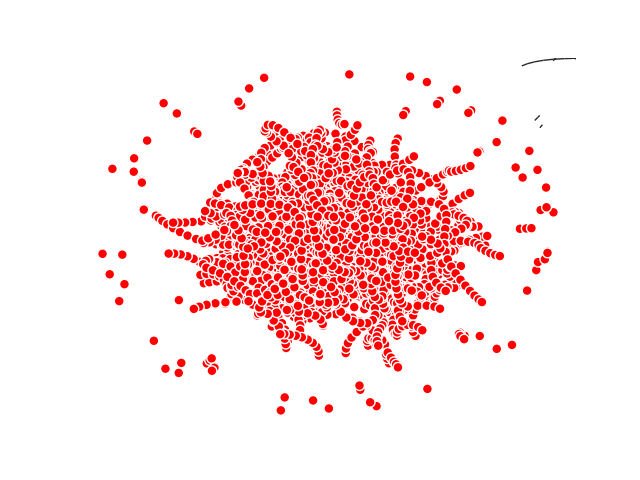

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms.approximation.dominating_set import min_weighted_dominating_set

from grave import plot_network

network = G.copy()

def color_fixed_coord(node_attrs):
    if node_attrs.get('coordinates', True):
        return {'color': 'red'}
    else:
        return {'color': 'black'}

fig, ax = plt.subplots()
plot_network(network, node_style=color_fixed_coord)


# NetworkX plotting

The NetworkX `spring_layout` allows a subset of fixed points

In [ ]:
# create pos as copy of coodinates for proper naming
w = nx.get_node_attributes(G, 'coordinates')
nx.set_node_attributes(G, w, 'pos')
G.nodes(data=True)

NodeDataView({'Abercorn Basin_0': {'street': 'Abercorn Basin', 'node_type': 'from-to', 'second_street': "Queen's Quay"}, 'Albert Bridge Road_1': {'street': 'Albert Bridge Road', 'node_type': 'from-to', 'second_street': 'Albert Bridge'}, 'Albert Bridge Road_2': {'street': 'Albert Bridge Road', 'node_type': nan, 'second_street': nan}, 'Albert Bridge Road_3': {'street': 'Albert Bridge Road', 'node_type': nan, 'second_street': nan}, 'Albert Bridge Road_4': {'street': 'Albert Bridge Road', 'node_type': nan, 'second_street': nan}, 'Albert Bridge Road_5': {'street': 'Albert Bridge Road', 'node_type': nan, 'second_street': nan}, 'Albert Bridge Road_6': {'street': 'Albert Bridge Road', 'node_type': nan, 'second_street': nan}, 'Albert Bridge Road_7': {'street': 'Albert Bridge Road', 'node_type': nan, 'second_street': nan}, 'Albert Bridge Road_8': {'street': 'Albert Bridge Road', 'node_type': nan, 'second_street': nan}, 'Albert Bridge Road_9': {'street': 'Albert Bridge Road', 'node_type': nan, 's

In [ ]:
#TODO: get coords to be read either as fixed and/or directly as pos
nodes_with_coordinates = [(node, data['coordinates']) for node, data in G.nodes(data=True) if 'coordinates' in data]
nodes_with_coordinates

NameError: name 'G' is not defined

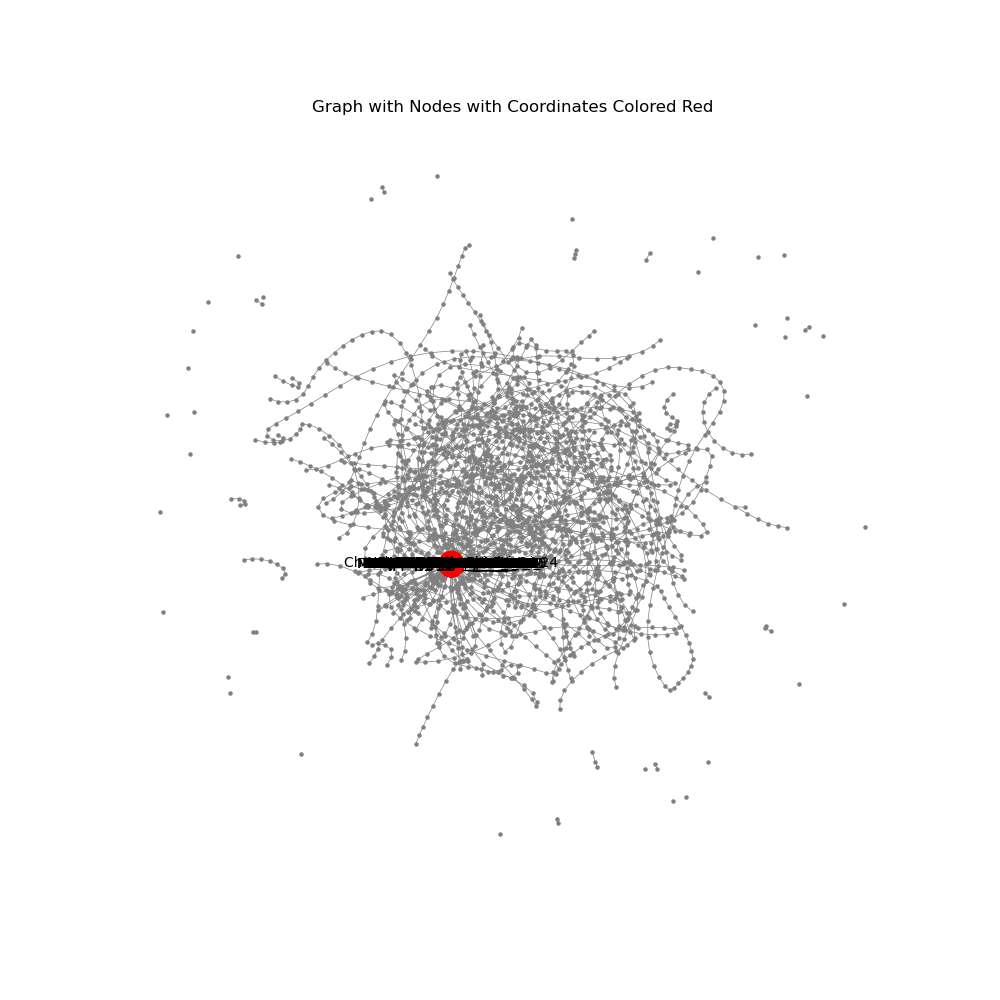

In [ ]:
pos = {node: coord for node, coord in nodes_with_coordinates}

# compute center and scale parameters for spring_layout
min_lat, min_lon = 54.57824002300004, -5.87340877594884
max_lat, max_lon = 54.618713694871445, -5.921828013100068

center = ((max_lat + min_lat) / 2, (max_lon + min_lon) / 2)
scale = max(max_lat - min_lat, max_lon - min_lon)

# compute spring layout with fixed positions, center, and scale
spring_pos = nx.spring_layout(G, pos=pos, fixed=pos, center=center, scale=scale)

# plot
plt.figure(figsize=(10, 10))

# draw nodes without coordinates
# draw nodes without coordinates
nx.draw_networkx_nodes(G, spring_pos, nodelist=[node for node in G.nodes if node not in pos], node_color='gray', node_size=5)
nx.draw_networkx_edges(G, spring_pos, edge_color='gray', width=0.5)

# draw nodes with coordinates (in red and with labels)
nx.draw_networkx_nodes(G, spring_pos, nodelist=[node for node in pos], node_color='red', node_size=300)
nx.draw_networkx_labels(G, spring_pos, labels={node: node for node in pos}, font_size=10, font_color='black')

plt.title('Graph with Nodes with Coordinates Colored Red')
plt.axis('off')
plt.show()

# OSMnx